      Temperature  Rainfall         ghg         ch4       date  quarter
0         7.72768  40.42580   16.900000   12.325000 1901-01-01        1
1         8.93600  12.30220   16.908333   12.329167 1901-02-01        1
2        16.96320  25.51190   16.916667   12.333333 1901-03-01        1
3        21.27410  14.29420   16.925000   12.337500 1901-04-01        2
4        26.04970  38.30460   16.933333   12.341667 1901-05-01        2
...           ...       ...         ...         ...        ...      ...
1387     27.63320  60.60610  183.666667  125.479167 2016-08-01        3
1388     26.71790  13.76940  184.333333  125.833333 2016-09-01        3
1389     22.39820   1.07552  185.000000  126.187500 2016-10-01        4
1390     15.76720   2.88480  185.666667  126.541667 2016-11-01        4
1391     12.87630   7.82298  186.333333  126.895833 2016-12-01        4

[1392 rows x 6 columns]


<ipython-input-1-6dd7f45d143a>:55: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr_dict[quarter], dtype=np.bool)


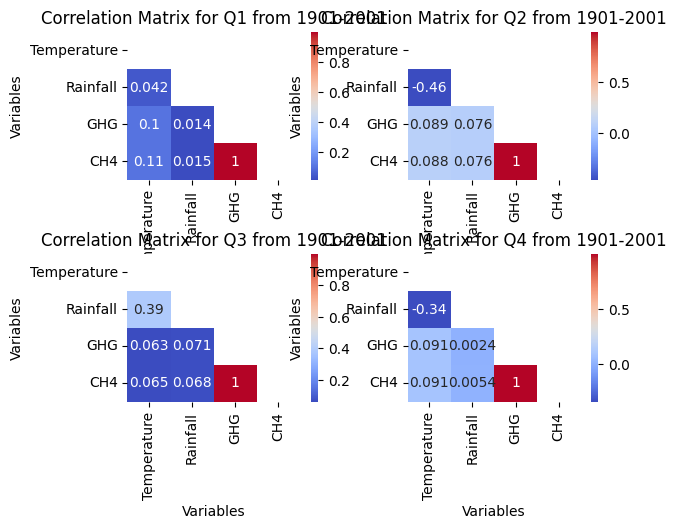

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist


# Load the data into a pandas dataframe
data = pd.read_csv('file.csv')

# Combine the year and month columns into a single datetime column
data['date'] = pd.to_datetime(data['year'].astype(str) + '-' + data['Month'], format='%Y-%B')

# Drop the original year and month columns
data = data.drop(['year', 'Month'], axis=1)

# Divide the date into quarters and add the quarter column
data['quarter'] = data['date'].dt.quarter
print(data)
# Select the columns for temperature, rainfall, GHG, and CH4
columns = ['Temperature', 'Rainfall', 'ghg', 'ch4']

# Fill in missing values with their respective mean value for that column
for col in columns:
    data[col] = data[col].fillna(data[col].mean())

# Divide the year into quarters and add the quarter column
data['Quarter'] = data['date'].dt.quarter

# Create a dictionary to store the correlation matrices for each quarter
corr_dict = {}

# Loop through each quarter and calculate the correlation matrix for temperature, rainfall, GHG, and CH4
for quarter in range(1, 5):
    # Select the data for the current quarter
    quarter_data = data[data['Quarter'] == quarter]
    
    # Select the columns for temperature, rainfall, GHG, and CH4
    quarter_data = quarter_data[columns]
    
    # Calculate the correlation matrix
    corr_matrix = quarter_data.corr()
    
    # Store the correlation matrix in the dictionary
    corr_dict[f'Q{quarter}'] = corr_matrix

# Plot the correlation matrices as lower triangle heatmaps
for i, quarter in enumerate(corr_dict.keys()):
    # Create a mask to plot only the lower triangle of the heatmap
    mask = np.zeros_like(corr_dict[quarter], dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    # Plot the heatmap with diagonal values included
    plt.subplot(2, 2, i+1)
    sns.heatmap(corr_dict[quarter], annot=True, cmap='coolwarm', mask=mask, 
                xticklabels=['Temperature', 'Rainfall', 'GHG', 'CH4'], 
                yticklabels=['Temperature', 'Rainfall', 'GHG', 'CH4'])
    
    # Set the title and axis labels
    plt.title(f'Correlation Matrix for {quarter} from 1901-2001')
    plt.xlabel('Variables')
    plt.ylabel('Variables')

# Adjust the spacing between the subplots
plt.subplots_adjust(hspace=0.5, wspace=0.3)

# Show the plot
plt.show()





In [ ]:
# Drop the original year and month columns
data = data.drop(['date', 'Quarter','quarter'], axis=1)
print(data)

# Perform hierarchical clustering analysis
dist_matrix = pdist(data, metric='euclidean')
hier_clust = linkage(dist_matrix, method='complete')

# Set the threshold for clustering
cluster_threshold = 2.5

# Assign each data point to a cluster
clusters = fcluster(hier_clust, t=cluster_threshold, criterion='distance')

      Temperature  Rainfall         ghg         ch4
0         7.72768  40.42580   16.900000   12.325000
1         8.93600  12.30220   16.908333   12.329167
2        16.96320  25.51190   16.916667   12.333333
3        21.27410  14.29420   16.925000   12.337500
4        26.04970  38.30460   16.933333   12.341667
...           ...       ...         ...         ...
1387     27.63320  60.60610  183.666667  125.479167
1388     26.71790  13.76940  184.333333  125.833333
1389     22.39820   1.07552  185.000000  126.187500
1390     15.76720   2.88480  185.666667  126.541667
1391     12.87630   7.82298  186.333333  126.895833

[1392 rows x 4 columns]


In [ ]:
# Split the data into training and testing sets
train_data = data.iloc[:int(len(data)*0.8), :]
test_data = data.iloc[int(len(data)*0.8):, :]

# Split the training data into training and validation sets
val_data = train_data.iloc[int(len(train_data)*0.8):, :]
train_data = train_data.iloc[:int(len(train_data)*0.8), :]

# Scale the data
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
val_data = scaler.transform(val_data)
test_data = scaler.transform(test_data)

def create_dataset(data, target, time_steps):
    X = []
    y = []
    for i in range(len(data)-time_steps):
        X.append(data[i:i+time_steps])
        y.append(target[i+time_steps])
    return np.array(X), np.array(y)


# Define the time steps and the number of features
time_steps = 5
num_features = train_data.shape[1]

# Create the training dataset
X_train, y_train = [], []
for i in range(time_steps, len(train_data)):
    X_train.append(train_data[i-time_steps:i])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Create the testing dataset
X_test, y_test = [], []
for i in range(time_steps, len(test_data)):
    X_test.append(test_data[i-time_steps:i])
    y_test.append(test_data[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

# Print the shapes of the datasets
print("Training set shape: ", X_train.shape, y_train.shape)
print("Validation set shape: ", val_data.shape)
print("Testing set shape: ", X_test.shape, y_test.shape)

Training set shape:  (885, 5, 4) (885,)
Validation set shape:  (223, 4)
Testing set shape:  (274, 5, 4) (274,)


In [ ]:
# Import required libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dropout, Dense


# Create the model
model = Sequential()
model.add(SimpleRNN(256, return_sequences=True, input_shape=(time_steps, num_features)))
model.add(Dropout(0.5))
model.add(SimpleRNN(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(SimpleRNN(64, return_sequences=True))
model.add(Dropout(0.5))
model.add(SimpleRNN(32))
model.add(Dropout(0.5))
model.add(Dense(units=1)) 

# Print the model summary
print(model.summary())

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

# Train the model
history = model.fit(X_train, y_train, epochs=400, batch_size=64, validation_data=(X_test, y_test), verbose=1)

# Predict the test data
y_pred = model.predict(X_test)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 5, 256)            66816     
                                                                 
 dropout_4 (Dropout)         (None, 5, 256)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 5, 128)            49280     
                                                                 
 dropout_5 (Dropout)         (None, 5, 128)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 5, 64)             12352     
                                                                 
 dropout_6 (Dropout)         (None, 5, 64)             0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 32)               

In [ ]:
n_features = 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train_data.reshape(-1, n_features))

# Inverse scale the data
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

# Calculate the evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
nmae_test = mae / (np.max(y_test) - np.min(y_test))
mse = mean_squared_error(y_test, y_pred)
nrmse_test = np.sqrt(mse) / (np.max(y_test) - np.min(y_test))

# Calculate the evaluation metrics for training set
y_train_pred = model.predict(X_train)
y_train = y_train.reshape(-1, 1)
y_train_pred = scaler.inverse_transform(y_train_pred.reshape(-1, 1))
mae_train = mean_absolute_error(y_train, y_train_pred)
nmae_train = mae_train / (np.max(y_train) - np.min(y_train))
mse_train = mean_squared_error(y_train, y_train_pred)
nrmse_train = np.sqrt(mse_train) / (np.max(y_train) - np.min(y_train))

# Calculate the average NMAE and NRMSE
nmae_avg = np.mean([nmae_train, nmae_test])
nrmse_avg = np.mean([nrmse_train, nrmse_test])

# Print the evaluation metrics
print("NMAE Train: ", nmae_train)
print("NMAE Test: ", nmae_test)
print("Average NMAE: ", nmae_avg)
print("NRMSE Train: ", nrmse_train)
print("NRMSE TEST:",nrmse_test)
print("Average NMAE: ", nmae_avg)

28/28 [==============================] - 0s 4ms/step
NMAE Train:  0.056223910776035835
NMAE Test:  0.046909833269396545
Average NMAE:  0.05156687202271619
NRMSE Train:  0.07052356567318
NRMSE TEST: 0.06276824637923487
Average NMAE:  0.05156687202271619


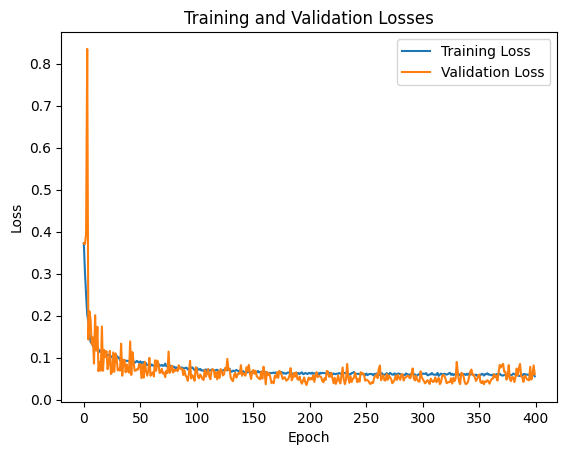

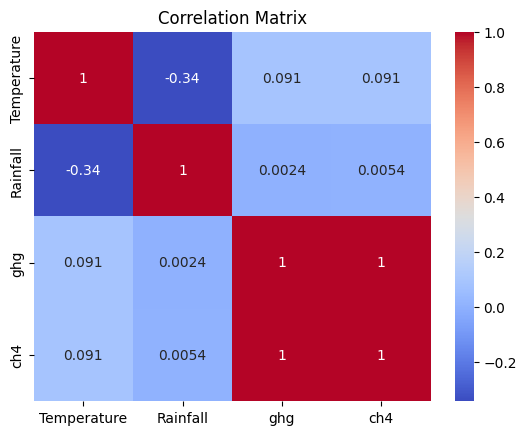

In [ ]:
# Plot the training and validation losses
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
import seaborn as sns
# Create a heatmap of the correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()